In [1]:
!pip install sentencepiece

In [2]:
!pip install transformers

In [3]:
!pip install nlp

In [4]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [5]:
!pip install seaborn

In [6]:
import time
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from nlp import load_dataset

from transformers import T5Tokenizer, T5ForConditionalGeneration

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def set_seeds(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

In [8]:
SEED = 42
set_seeds(SEED)

In [9]:
dataset = load_dataset('aeslc')

Using custom data configuration default


In [10]:
dataset.keys()

dict_keys(['train', 'validation', 'test'])

In [11]:
train_df = pd.DataFrame(dataset["train"])
val_df = pd.DataFrame(dataset["validation"])
test_df = pd.DataFrame(dataset["test"])

In [12]:
train_df.shape

(14436, 2)

In [13]:
val_df.shape

(1960, 2)

In [14]:
test_df.shape

(1906, 2)

In [15]:
print(f"Sample: \n"
     f"Email: {train_df.iloc[0]['email_body']}\n"
     f"Subject: {train_df.iloc[0]['subject_line']}")

Sample: 
Email: Greg/Phillip,  Attached is the Grande Communications Service Agreement.
The business points can be found in Exhibit C.  I Can get the Non-Disturbance agreement after it has been executed by you and Grande.
I will fill in the Legal description of the property one I have received it.
Please execute and send to:  Grande Communications, 401 Carlson Circle, San Marcos Texas, 78666 Attention Hunter Williams.
<<Bishopscontract.doc>>

Subject: Service Agreement


In [16]:
# We will use T5 for generating the subject line
train_df.email_body = "summarize: " + train_df.email_body
train_df.head()

,email_body,subject_line
0,"summarize: Greg/Phillip, Attached is the Gran...",Service Agreement
1,summarize: Phillip & Keith Attached is the fi...,Bishops Corner
2,summarize: Your Internet Banking accounts are ...,Internet Banking
3,summarize: To our IBS Customers that are still...,Internet Banking
4,summarize: Phillip Good Morning!\nI hope you h...,SMEs for expert stories


In [17]:
val_df.email_body = "summarize: " + val_df.email_body
test_df.email_body = "summarize: " + test_df.email_body

In [23]:
percentage_of_data = 0.5

In [24]:
train_df = train_df.sample(frac=percentage_of_data, random_state=SEED).reset_index(drop=True)
val_df = val_df.sample(frac=percentage_of_data, random_state=SEED).reset_index(drop=True)
test_df = test_df.sample(frac=percentage_of_data, random_state=SEED).reset_index(drop=True)

In [25]:
emails = train_df.email_body.values
email_lengths = [len(email.split()) for email in emails]

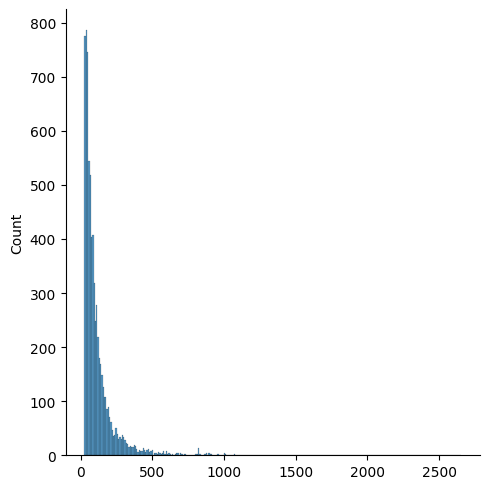

In [26]:
sns.displot(email_lengths)

In [27]:
subjects = train_df.subject_line.values
subject_lengths = [len(subject.split()) for subject in subjects]

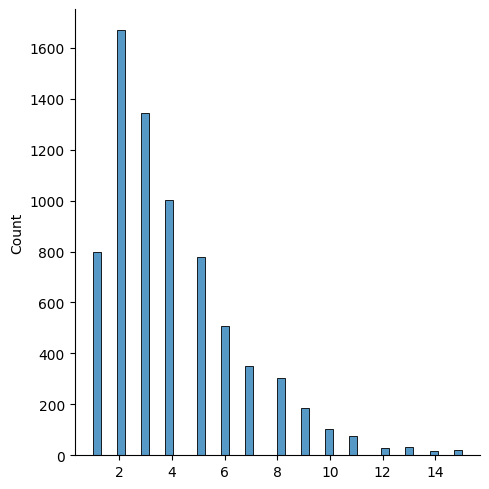

In [28]:
sns.displot(subject_lengths)

In [30]:
train_df.shape

(7218, 2)

In [31]:
val_df.shape

(980, 2)

In [33]:
val_df.head()

,email_body,subject_line
0,summarize: One of Travel Agency in the Park's ...,DRAFT- TAP Power Outage\n
1,summarize: Wade here are the wiring instructio...,CAISO/Calpine\n
2,"summarize: Maria, please take a look at this l...",EnronOnline Credit Derivatives Propsoed Refere...
3,summarize: Kim Gil Hyung/HR & Admin Team 2001-...,[Urgent]Approval for disposition of Ildong Cou...
4,summarize: Today we released additional inform...,SEC Information/Earnings Restatement\n


In [29]:
MODEL_NAME = "t5-base"
MODEL_PATH = "t5model.pt"
TOKENIZER = T5Tokenizer.from_pretrained(MODEL_NAME, model_max_length=512)

In [36]:
MODEL_MAX_LENGTH = 512
SUMMARY_LEN = 32

BATCH_SIZE = 2
EPOCHS = 2
LR = 1e-4

In [44]:
class EmailDataset(Dataset):
    def __init__(self, df, tokenizer, email_len, summary_len):
        super(EmailDataset, self).__init__()
        self.tokenizer = tokenizer
        self.data = df
        self.email_len = email_len
        self.summary_len = summary_len
        self.email_body = df.email_body
        self.subject_line = df.subject_line
        
    def __len__(self):
        return len(self.subject_line)
    
    def __getitem__(self, index):
        email_ = str(self.email_body[index])
        email_ = " ".join(email_.split())
        
        subject_ = str(self.subject_line[index])
        subject_ = " ".join(subject_.split())
        
        email = self.tokenizer.encode_plus(
            email_,
            max_length=self.email_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )
        
        subject = self.tokenizer.encode_plus(
            subject_,
            max_length=self.summary_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            "email_ids": email['input_ids'].flatten(),
            "email_mask": email['attention_mask'].flatten(),
            "subject_ids": subject['input_ids'].flatten(),
            "subject_mask": subject['attention_mask'].flatten()
        }

In [45]:
train_dataset = EmailDataset(train_df, TOKENIZER, MODEL_MAX_LENGTH, SUMMARY_LEN)
val_dataset = EmailDataset(val_df, TOKENIZER, MODEL_MAX_LENGTH, SUMMARY_LEN)
test_dataset = EmailDataset(test_df, TOKENIZER, MODEL_MAX_LENGTH, SUMMARY_LEN)

In [46]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, pin_memory=True)

In [47]:
sample = next(iter(train_dataloader))
sample['email_ids'].shape, sample['email_mask'].shape, sample['subject_ids'].shape

(torch.Size([2, 512]), torch.Size([2, 512]), torch.Size([2, 32]))

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [50]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [51]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [63]:
def train(dataloader, model, tokenizer, optimizer, device):
    model.train()
    epoch_loss = 0
    
    for idx, batch in enumerate(dataloader):
        input_ids = batch["email_ids"].to(device)
        attention_mask = batch["email_mask"].to(device)

        target_ids = batch["subject_ids"].to(device)
        
        y_ids = target_ids[:, :-1].contiguous()
        lm_labels = target_ids[:, 1:].clone().detach()
        lm_labels[target_ids[:, 1:] == tokenizer.pad_token_id] = -100

        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=y_ids,
            labels=lm_labels
        )
        

        loss = outputs[0]
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

        if idx%1000 == 0:
            print(f"Step: {idx}/{len(dataloader)} | Loss: {loss.item()}")
    return epoch_loss / len(dataloader)

In [70]:
def evaluate(data_loader, model, tokenizer, device):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            input_ids = batch["email_ids"].to(device)
            attention_mask = batch["email_mask"].to(device)

            target_ids = batch["subject_ids"].to(device)
            
            y_ids = target_ids[:, :-1].contiguous()
            lm_labels = target_ids[:, 1:].clone().detach()
            lm_labels[target_ids[:, 1:] == tokenizer.pad_token_id] = -100

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                decoder_input_ids=y_ids,
                labels=lm_labels
            )

            loss = outputs[0]
            epoch_loss += loss.item()

            if idx%1000 == 0:
                print(f"Val Step: {idx}/{len(data_loader)} | Loss: {loss.item()}")
    
    return epoch_loss / len(data_loader)

In [68]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs 

In [71]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss = train(train_dataloader, model, TOKENIZER, optimizer, device)
    val_loss = evaluate(val_dataloader, model, TOKENIZER, device)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), MODEL_PATH)
    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\t Train Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):5.4f}")
    print(f"\t Val Loss: {val_loss:.3f} | Val PPL: {np.exp(val_loss):5.4f}")

Step: 0/3609 | Loss: 1.241208791732788
Step: 1000/3609 | Loss: 2.3733069896698
Step: 2000/3609 | Loss: 0.46842652559280396
Step: 3000/3609 | Loss: 2.4286186695098877
Val Step: 0/490 | Loss: 3.5139970779418945
Epoch: 01 | Epoch Time: 20m 25s
	 Train Loss: 1.341 | Train PPL: 3.8235
	 Val Loss: 2.589 | Val PPL: 13.3210
Step: 0/3609 | Loss: 1.535526156425476
Step: 1000/3609 | Loss: 1.342257022857666
Step: 2000/3609 | Loss: 0.42206230759620667
Step: 3000/3609 | Loss: 1.4714113473892212
Val Step: 0/490 | Loss: 3.4885737895965576
Epoch: 02 | Epoch Time: 20m 24s
	 Train Loss: 1.053 | Train PPL: 2.8659
	 Val Loss: 2.771 | Val PPL: 15.9769


In [72]:
test_loss = evaluate(test_dataloader, model, TOKENIZER, device)
print(f"\t Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):5.4f}")

Val Step: 0/477 | Loss: 1.818028450012207
	 Test Loss: 2.885 | Test PPL: 17.8991


In [77]:
def inference(model, email, tokenizer, device):
    model.eval()

    email = "summarize: " + email

    source = tokenizer.encode_plus(
        email,
        max_length=MODEL_MAX_LENGTH,
        padding='max_length',
        return_attention_mask=True,
        truncation=True,
        return_tensors='pt')
    
    with torch.no_grad():
        ids = source["input_ids"].to(device)
        mask = source["attention_mask"].to(device)

        generated_ids = model.generate(
            input_ids=ids,
            attention_mask=mask,
            max_length=10,
            num_beams=2,
            repetition_penalty=2.5,
            length_penalty=1.0,
            early_stopping=True
        )

        summary = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]

    return summary[0]

In [83]:
email = dataset["test"][500]["email_body"]

In [84]:
email

'As of start of business, Wednesday, February 6th, you will have been migrated to the UBSW Energy environment.\nHere are a couple of quick tips and reminders to get you going:  ?\nYou will log in with your Enron NT ID, this will not change  ?\nYou will be asked to change your password, follow the standard Enron rules  ?\nYour desktop will look the same  ?\nEmail will not be affected until Day 1, on which you will have your new UBSWE email address  ?\nAll compliant data and email should be copied to the UBSWE environment no later than Midnight (CST), Thursday, February 7, 2002 (see Data Migration Protocol email for compliancy direction)  ?\nNo data or emails are to be deleted from the system   If you have any questions or concerns, please contact the Resolution Center at x 3-1411\n'

In [85]:
email = " ".join(email.split()).strip()
subject = inference(model, email, TOKENIZER, device)
print(subject)

UBSW Data Migration Protocol


In [86]:
dataset['test'][500]['subject_line']

'Quick Tips for the UBSWE migration\n'